In [344]:
! pip install pandas-ta

In [345]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler

In [346]:
df1 = pd.read_csv('merged_technology_news_data_future_3months.csv')
df2 = pd.read_csv('technology_news_data_50Daily.csv')

# Combine the dataframes by row
df_combined = pd.concat([df1, df2], ignore_index=True)

# Optional: Save the combined dataframe to a new CSV file
df_combined.to_csv('combined_file.csv', index=False)

In [347]:
def create_processed_data_df(start, end, ticker, sentiment_csv):
  stock_df = yf.download(ticker, start=start, end=end)
  stock_df = stock_df.xs(ticker, level='Ticker', axis=1)
  stock_df['time_published'] = stock_df.index
  stock_df['time_published'] = pd.to_datetime(stock_df['time_published'])
  stock_df['time_published'] = stock_df['time_published'].dt.date
  print("stock_df")


  #Adding indicators
  stock_df['RSI']=ta.rsi(stock_df.Close, length=15)
  stock_df['EMAF']=ta.ema(stock_df.Close, length=20)
  stock_df['EMAM']=ta.ema(stock_df.Close, length=100)
  stock_df['EMAS']=ta.ema(stock_df.Close, length=150)

  stock_df['Target'] = stock_df['Adj Close']-stock_df.Open
  stock_df['Target'] = stock_df['Target'].shift(-1)

  stock_df['TargetClass'] = [1 if stock_df.Target[i]>0 else 0 for i in range(len(stock_df))]

  stock_df['TargetNextClose'] = stock_df['Adj Close'].shift(-1)

  stock_df.dropna(inplace=True)
  stock_df.reset_index(inplace = True)
  stock_df.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

  # stock_df_set = stock_df.iloc[:, 0:11]#.values
  # pd.set_option('display.max_columns', None)
  display(stock_df)


  news_df = pd.read_csv(sentiment_csv)
  news_df['time_published'] = pd.to_datetime(news_df['time_published'])
  news_df['time_published'] = news_df['time_published'].dt.date
  news_df = news_df[news_df['title'] != 'Before you continue']


  df1 = stock_df.copy(deep=True)
  df2 = news_df[['time_published', 'source', 'overall_sentiment_score']]
  average_sentiment_df = df2.groupby(['time_published', 'source'], as_index=False)['overall_sentiment_score'].mean()
  average_sentiment_df.rename(columns={'overall_sentiment_score': 'average sentiment score'}, inplace=True)
  pivot_df = average_sentiment_df.pivot(index='time_published', columns='source', values='average sentiment score')
  pivot_df.reset_index(inplace=True)
  pivot_df.fillna(-1, inplace=True)
  pivot_df.replace(-1, np.nan, inplace=True)
  combined_df = pd.merge(df1, pivot_df, on='time_published', how='inner')
  # # combined_df['time_published'] = pd.to_datetime(combined_df['time_published'])
  # # combined_df['time_published'] = (combined_df['time_published'] - pd.to_datetime('1970-01-01')).dt.days
  # df_encoded = pd.get_dummies(combined_df, columns=['source'])
  # display(df_encoded)

  display(combined_df)
  # List of columns representing sentiment scores
  news_sentiment_columns = combined_df.drop(['Adj Close', 'High', 'Low', 'Open', 'time_published', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'Target', 'TargetClass', 'TargetNextClose'], axis=1).columns.tolist()

  # Calculate the mean sentiment across all news sources
  combined_df['aggregate_sentiment_mean'] = combined_df[news_sentiment_columns].mean(axis=1)

  # Calculate other possible aggregation metrics (optional)
  combined_df['aggregate_sentiment_median'] = combined_df[news_sentiment_columns].median(axis=1)
  combined_df['aggregate_sentiment_std'] = combined_df[news_sentiment_columns].std(axis=1)

  # Fill missing values with 0 before aggregation
  combined_df[news_sentiment_columns] = combined_df[news_sentiment_columns].fillna(0)

  # Recalculate the mean sentiment
  combined_df['aggregate_sentiment_mean'] = combined_df[news_sentiment_columns].mean(axis=1)

  # print(combined_df[['time_published', 'aggregate_sentiment_mean']].head())
  final_df = combined_df[['Adj Close', 'High', 'Low', 'Open', 'aggregate_sentiment_mean', 'aggregate_sentiment_median', 'aggregate_sentiment_std', 'Target', 'TargetClass', 'TargetNextClose']]
  time_published = combined_df['time_published'].values
  # final_df = combined_df[['Adj Close', 'High', 'Low', 'Open', 'Target', 'TargetClass', 'TargetNextClose']]


  data_set = final_df.iloc[:, 0:11]#.values
  pd.set_option('display.max_columns', None)

  return final_df, time_published

In [348]:
final_df, time_published = create_processed_data_df("2023-09-01", "2024-12-01", "QQQ", 'combined_file.csv')
# spy = yf.Ticker("SPY")
display(final_df)

[*********************100%***********************]  1 of 1 completed
<ipython-input-347-dace1c3b654e>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_df['TargetClass'] = [1 if stock_df.Target[i]>0 else 0 for i in range(len(stock_df))]


stock_df


Price,Adj Close,High,Low,Open,time_published,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,439.283508,442.500000,439.200012,441.410004,2024-04-08,51.596656,440.755223,417.497347,400.447800,-2.051361,0,440.908630
1,440.908630,443.239990,437.440002,442.959991,2024-04-09,53.440418,440.895679,417.987102,401.001207,0.060181,1,437.060181
2,437.060181,439.239990,436.279999,437.000000,2024-04-10,48.730694,440.655138,418.390724,401.496157,3.779236,1,444.039246
3,444.039246,446.329987,437.959991,440.260010,2024-04-11,56.226364,441.104172,418.924967,402.077268,-4.139557,0,436.960449
4,436.960449,442.239990,436.880005,441.100006,2024-04-12,48.517730,440.834250,419.308037,402.556642,-12.287994,0,429.772003
...,...,...,...,...,...,...,...,...,...,...,...,...
159,504.980011,506.959991,497.559998,506.239990,2024-11-21,55.845366,501.462584,482.238504,471.273298,1.369995,1,505.790009
160,505.790009,506.529999,502.779999,504.420013,2024-11-22,56.510283,501.874719,482.704870,471.730473,-3.309998,0,506.589996
161,506.589996,511.450012,504.260010,509.899994,2024-11-25,57.192425,502.323793,483.177843,472.192188,1.230011,1,509.309998
162,509.309998,510.140015,507.230011,508.079987,2024-11-26,59.506223,502.989146,483.695311,472.683815,-2.870026,0,505.299988


,Adj Close,High,Low,Open,time_published,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose,Al Jareeza,Associated Press,Barrons,Benzinga,Business Insider,Business Standard,CNBC,CNN,Canada Newswire,Cointelegraph,Decrypt.co,Financial News London,Financial Times,Forbes,Fox Business News,GlobeNewswire,Investing News Network,Investor Ideas,Investors Business Daily,Kiplinger,MarketWatch,Money Control,Money Morning,Motley Fool,New York Times,PR Newswire,PennyStocks.com,Reuters,South China Morning Post,StockMarket.com,Stocknews.com,The Atlantic,The Economist,The Financial Express,The Street,The Week News,UPI Business,Wall Street Journal,Zacks Commentary
0,439.283508,442.500000,439.200012,441.410004,2024-04-08,51.596656,440.755223,417.497347,400.447800,-2.051361,0,440.908630,NaN,NaN,NaN,0.103171,0.182876,NaN,0.256322,0.047593,NaN,0.162014,NaN,NaN,NaN,0.061233,0.318206,0.123460,NaN,NaN,0.202369,NaN,NaN,0.012076,NaN,0.304409,NaN,0.220255,NaN,NaN,0.033336,NaN,NaN,-0.033848,NaN,NaN,NaN,NaN,NaN,NaN,0.209103
1,440.908630,443.239990,437.440002,442.959991,2024-04-09,53.440418,440.895679,417.987102,401.001207,0.060181,1,437.060181,NaN,-0.031581,NaN,0.267301,0.177943,NaN,NaN,-0.020835,0.403993,0.143970,-0.045746,NaN,NaN,0.158955,0.032111,0.115736,NaN,NaN,0.055548,NaN,NaN,0.130222,NaN,0.204497,NaN,0.404966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.193731
2,437.060181,439.239990,436.279999,437.000000,2024-04-10,48.730694,440.655138,418.390724,401.496157,3.779236,1,444.039246,NaN,0.055890,NaN,0.182556,0.033111,NaN,NaN,-0.020894,NaN,NaN,NaN,NaN,NaN,0.132751,NaN,0.161709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352193,NaN,NaN,NaN,NaN,NaN,0.241548,NaN,0.173894,NaN,NaN,NaN,NaN,0.163428
3,444.039246,446.329987,437.959991,440.260010,2024-04-11,56.226364,441.104172,418.924967,402.077268,-4.139557,0,436.960449,NaN,-0.216174,NaN,0.189119,NaN,NaN,0.084168,0.013055,0.091346,NaN,NaN,NaN,NaN,0.121310,NaN,0.090305,NaN,NaN,0.205168,NaN,NaN,NaN,NaN,0.159242,NaN,0.234550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.200163
4,436.960449,442.239990,436.880005,441.100006,2024-04-12,48.517730,440.834250,419.308037,402.556642,-12.287994,0,429.772003,NaN,-0.004818,0.269007,0.201153,0.153252,NaN,NaN,NaN,0.161976,NaN,NaN,NaN,NaN,0.111187,NaN,0.170038,0.15306,NaN,0.128234,NaN,NaN,NaN,NaN,NaN,NaN,0.177232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.259303,NaN,NaN,NaN,NaN,0.163071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,504.980011,506.959991,497.559998,506.239990,2024-11-21,55.845366,501.462584,482.238504,471.273298,1.369995,1,505.790009,NaN,NaN,NaN,0.246117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.259305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.268843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.170029
160,505.790009,506.529999,502.779999,504.420013,2024-11-22,56.510283,501.874719,482.704870,471.730473,-3.309998,0,506.589996,NaN,NaN,NaN,0.245895,NaN,NaN,0.141104,NaN,NaN,NaN,0.094482,NaN,NaN,NaN,NaN,0.219918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.212313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275693
161,506.589996,511.450012,504.260010,509.899994,2024-11-25,57.192425,502.323793,483.177843,472.192188,1.230011,1,509.309998,NaN,NaN,NaN,0.269008,NaN,NaN,NaN,NaN,NaN,NaN,0.127783,NaN,NaN,NaN,NaN,0.259463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.099632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.189632
162,509.309998,510.140015,507.230011,508.079987,2024-11-26,59.506223,502.989146,483.695311,472.683815,-2.870026,0,505.299988,NaN,NaN,NaN,0.187094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.257861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.134664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.211099


,Adj Close,High,Low,Open,aggregate_sentiment_mean,aggregate_sentiment_median,aggregate_sentiment_std,Target,TargetClass,TargetNextClose
0,439.283508,442.500000,439.200012,441.410004,0.056476,0.162014,0.108029,-2.051361,0,440.908630
1,440.908630,443.239990,437.440002,442.959991,0.056175,0.143970,0.139817,0.060181,1,437.060181
2,437.060181,439.239990,436.279999,437.000000,0.037851,0.162568,0.107070,3.779236,1,444.039246
3,444.039246,446.329987,437.959991,440.260010,0.030058,0.121310,0.125926,-4.139557,0,436.960449
4,436.960449,442.239990,436.880005,441.100006,0.049813,0.162524,0.070360,-12.287994,0,429.772003
...,...,...,...,...,...,...,...,...,...,...
159,504.980011,506.959991,497.559998,506.239990,0.024213,0.252711,0.045005,1.369995,1,505.790009
160,505.790009,506.529999,502.779999,504.420013,0.030498,0.216116,0.067776,-3.309998,0,506.589996
161,506.589996,511.450012,504.260010,509.899994,0.024244,0.189632,0.075995,1.230011,1,509.309998
162,509.309998,510.140015,507.230011,508.079987,0.020275,0.199097,0.051267,-2.870026,0,505.299988


In [349]:
def create_scaled_dataset(df,  time_published, MinMaxScaler=MinMaxScaler, backcandles=30):
  sc = MinMaxScaler(feature_range=(0,1))
  # data_set_scaled = sc.fit_transform(data_set)
  # print(data_set_scaled)
  data_set = df.to_numpy()
  # multiple feature from data provided to the model
  X = []
  corresponding_times = []
  print(data_set.shape[0])
  for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
      X.append([])
      for i in range(backcandles, data_set.shape[0]):#backcandles+2
          X[j].append(data_set[i-backcandles:i, j])

  for i in range(backcandles, data_set.shape[0]):  # Starting from backcandles to get the correct times
    # Append the time corresponding to the last time step of each sample
    corresponding_times.append(time_published[i])
  corresponding_times = np.array(corresponding_times)


  #move axis from 0 to position 2
  X=np.moveaxis(X, [0], [2])

  #Erase first elements of y because of backcandles to match X length
  X, yi =np.array(X), np.array(data_set[backcandles:,-1])
  y=np.reshape(yi,(len(yi),1))
  # print(X)
  print(X.shape)
  # print(y)
  print(y.shape)

  from sklearn.preprocessing import MinMaxScaler
  sc_X = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))

  X_shape = X.shape
  X_reshaped = X.reshape(-1, X.shape[2])

  X_reshaped_scaled = sc_X.fit_transform(X_reshaped)
  X = X_reshaped_scaled.reshape(X_shape[0], X_shape[1], -1)
  y = sc_y.fit_transform(y)
  return X, y, sc_X, sc_y, corresponding_times

In [350]:
X, y, sc_X, sc_y, corresponding_times = create_scaled_dataset(final_df, time_published, MinMaxScaler)

164
(134, 30, 8)
(134, 1)


In [351]:
# split data into train test sets
splitlimit = 92
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
time_published_train, time_published_test = corresponding_times[:splitlimit], corresponding_times[splitlimit:]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(sc_y.inverse_transform([y_train[-1]]), time_published_train[-1])
print(sc_y.inverse_transform([y_test[-1]]), time_published_test[-1])
# print(y_train)

92
(92, 30, 8) (42, 30, 8)
(92, 1) (42, 1)
[[481.26998901]] 2024-09-30
[[509.73999023]] 2024-11-27


In [352]:
# test_df, time_published_test = create_processed_data_df('2023-09-01', '2024-11-01', 'QQQ', 'combined_file.csv')

# X_test, y_test, sc_X_test, sc_y_test, time_published_test = create_scaled_dataset(test_df, time_published_test)
# display(time_published_test)
# # Filter test_df to only include rows with time_published > '2024-09-01'
# test_df = test_df.loc[time_published_test  > pd.to_datetime('2024-09-01')]

# # Apply the same filter to the other DataFrames using the same index from filtered test_df
# X_test = X_test.loc[test_df.index]
# y_test = y_test.loc[test_df.index]
# sc_X_test = sc_X_test.loc[test_df.index]
# sc_y_test = sc_y_test.loc[test_df.index]
# time_published_test = time_published_test.loc[test_df.index]

In [353]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

np.random.seed(506)
backcandles = 30

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 287ms/step - loss: 0.0898 - val_loss: 0.0318
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0252 - val_loss: 0.0780
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0234 - val_loss: 0.0157
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0202 - val_loss: 0.0307
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0194 - val_loss: 0.0529
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0203 - val_loss: 0.0259
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0162 - val_loss: 0.0256
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0138 - val_loss: 0.0444
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.0155 - val_loss: 0.0222
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.0164 - val_loss: 0.0290
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.0133 - val_loss: 0.0229
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0117 - val_los

In [354]:
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on test set: {loss}")
y_pred = model.predict(X_test)
for i in range(15):
    print(y_pred[i], y_test[i])

Mean Squared Error on test set: 0.06051572784781456
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step
[0.50336707] [0.59752502]
[0.5298428] [0.5930237]
[0.53113765] [0.66466663]
[0.5357983] [0.59940041]
[0.5604169] [0.68942254]
[0.5679354] [0.73755957]
[0.59646875] [0.73055786]
[0.62153774] [0.74018511]
[0.63533944] [0.79194815]
[0.63987666] [0.70880258]
[0.6372924] [0.70955273]
[0.6002962] [0.71380374]
[0.52733785] [0.75406376]
[0.4794075] [0.76594186]
[0.47619015] [0.77269326]


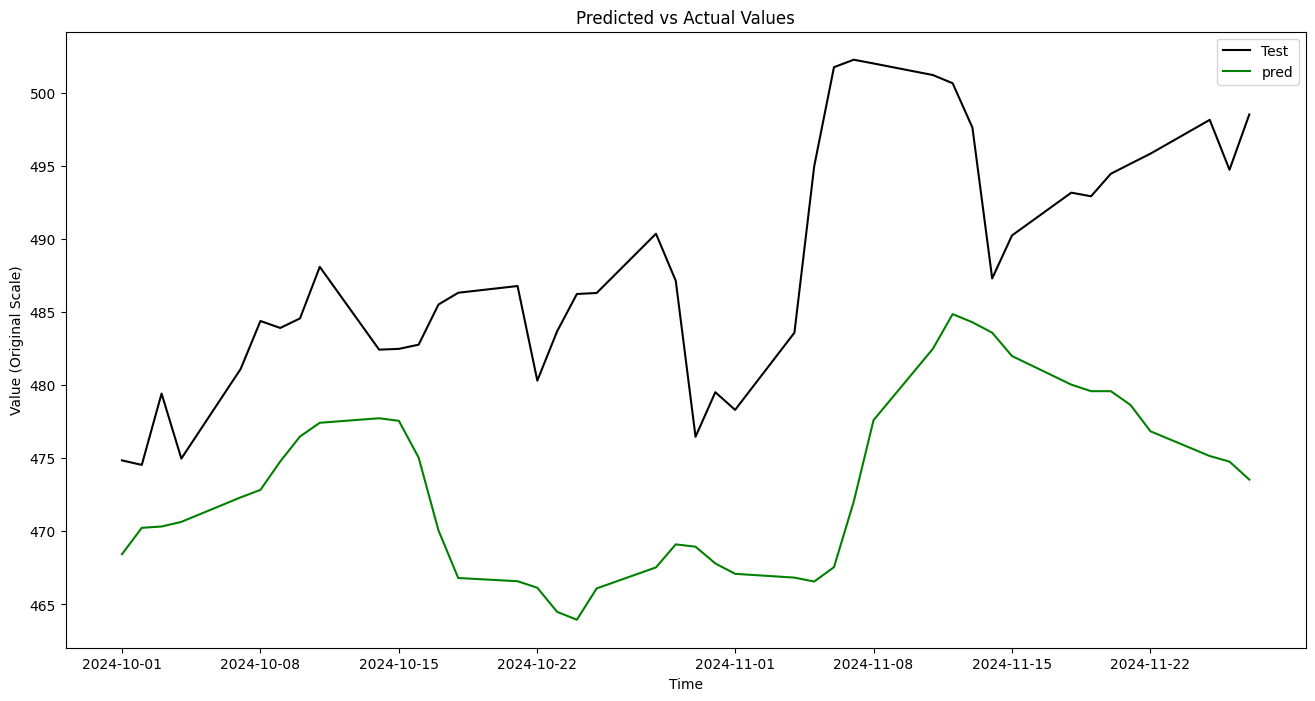

In [355]:
#Model only predicts 1 day in advance (The NextTargetClose)
y_test_original = sc_y.inverse_transform(y_test)
y_pred_original = sc_y.inverse_transform(y_pred)

plt.figure(figsize=(16,8))
plt.plot(time_published_test, y_test_original, color = 'black', label = 'Test')
plt.plot(time_published_test, y_pred_original, color = 'green', label = 'pred')
plt.xlabel('Time')
plt.ylabel('Value (Original Scale)')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()